In [1]:
"""
Created on Thu May 7 16:13:45 2020

@author: anish pratheepkumar
"""
#This is a work to recreate and understand the experiencor 
#implementation of YOLOV3 in Keras

'\nCreated on Thu May 7 16:13:45 2020\n\n@author: anish pratheepkumar\n'

In [2]:
#import necessary libraries
import os
import sys
import numpy as np
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model
import struct
import cv2

In [3]:
#limitting the numpy output to get the complete representation instead of a summary
np.set_printoptions(threshold=sys.maxsize)

In [4]:
#defining convolutional block creation in terms of Darknet implementation
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # darknet padding style(only pad left and top)
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # darknet padding style(only pad left and top)
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [5]:
#defining the YOLOV3 model, Here a 3 scale prediction is implemented
#skip connections exists upto 74 layers(mainly in the backbone Darknet53)
#Layer 82 prediction has shape of 13x13 and detects large objects
#Layer 94 prediction has shape of 26x26 and detects medium objects
#Layer 106 prediction has a shape of 52x52 and detects small objects
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    #defining the model with input and outputs(since 3 predictions are made)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

In [7]:
#defining the model based on the above YOLOV3 model function
model = make_yolov3_model()

In [8]:
#working with pretrained weights and setting up a class to read the same from weight_file
#struct.unpack will unpack 'C' structs into 'Python' values
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0  #initialise local variable to collect bnorm parameters
        self.all_weights = np.frombuffer(binary, dtype='float32') #getting numpy array from the buffer file of weights
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                
                #collecting parameters of the batch norm layer for the corresponding conv layer
                if i not in [81, 93, 105]: #list include layers prior to detection layer, these dont have batch normalisation
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)
                    #the parameters beta&gamma of bnorm and the mean & var are collected from weight file 
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  
                
                #collecting weights and biases of the conv layer with out bnorm
                #collecring weights for the conv layer with bnorm layer
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     #this stands for residuals in the skip connection concept
    
    def reset(self):
        self.offset = 0


In [9]:
#loading the weights into the YOLO model created 
#first instantiate an object of the WeightReader class also pass the weight file as an input argument
weight_reader = WeightReader('yolov3.weights')

In [10]:
#Now load the weights using set_weights methods inside the class
weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [23]:
#Now we have a YOLOV3 model with keras(python) compatible weights loaded inside it.
#saving this model into a HDF5 binary data format using h5py package
#model.save('model.h5')

In [11]:
#performing object detection on an image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [24]:
#saving the actual heigh and width of the image to rescale the detected
#bounding boxes to the size suitable to objects in the actual image
image = load_img('im7.jpg')
image_w, image_h = image.size
#OLOmodel desired input shape
input_w, input_h = 416, 416

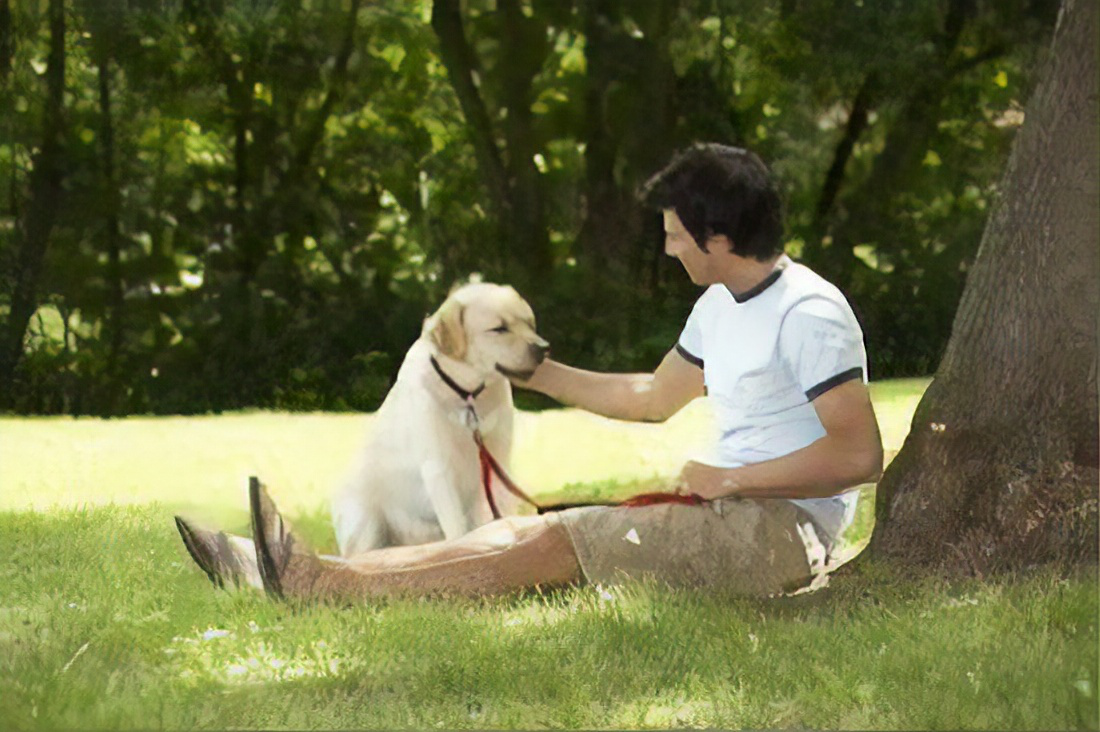

In [25]:
image

In [27]:
#loading a sample image and resizing it into the YOLOmodel desired shape
image = load_img('im7.jpg', target_size=(input_w, input_h))
#PythonImageLibrary format is to be converted into a numpy array
image = img_to_array(image)
#setting numpy array data type as float32
image = image.astype('float32')
#normalise the pixel values to be bounded between 0 and 1
image /= 255.0

In [28]:
print(image.shape)
image = image[None, :, :, :]
print(image.shape)

(416, 416, 3)
(1, 416, 416, 3)


In [29]:
#predict output for the loaded numpy array image
prediction = model.predict(image)

In [30]:
#Getting shape of the predicted arrays
print([a.shape for a in prediction])
#we can note the 3 scale prediction shapes(13x13, 26x26 & 52x52)
#further 255 => 

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [31]:
#Now we need to do postprocessing on the output

In [32]:
#YOLOV3 adopt logistic regression at the end rather than the softmax in old version
#implementing sigmoid function
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [34]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

In [35]:

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]  #height and width of the prediction
    nb_box = 3                         #no of bounding boxes per grid cell
    netout = netout.reshape((grid_h, grid_w, nb_box, -1)) #last dimension => 5+class probabilities
    nb_class = netout.shape[-1] - 5    #no of classes              

    boxes = []                         

    netout[..., :2]  = _sigmoid(netout[..., :2])    #(x,y) of all the anchors in prediction
    netout[..., 4:]  = _sigmoid(netout[..., 4:])    #objecness+class prob of all the anchor boxes
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:] #element wise multiplication of the objectness with classprob to calculate score for each object class
    netout[..., 5:] *= netout[..., 5:] > obj_thresh #eliminating classes which have scores less than the threshold value

    for i in range(grid_h*grid_w):
        #iterate over each gridcell in each epoch
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            #objectness is the 4th element of each bounding box vector(1box has 85 elements)
            objectness = netout[int(row)][int(col)][b][4]
            
            #extract bounding box only if the objectness is above the threshold else continue           
            if(objectness <= obj_thresh).all(): continue
            
            #(x,y,w,h) are the first 4 elements
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            
            #b_x = sigmoid(t_x)+c_x & b_y = sigmoid(t_y)+c_y
            x = (col + x) / grid_w # centre x value of gridcell w.r.t image width=>[0,1](it is w.r.t gridcell in the prediction)
            y = (row + y) / grid_h # centre y value of gridcell w.r.t image height=>[0,1]
            #b_w = P_w * exp(t_w) & b_h = p_h*exp(t_h)
            w = anchors[2 * b + 0] * np.exp(w) / net_w #w.r.t network input image width=>[0,1]
            h = anchors[2 * b + 1] * np.exp(h) / net_h #w.r.t network input image height=>[0,1]  
            
            #last 80 elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes #all the boxes in all a particular scale predictions are in this list

In [36]:
#define the anchors for 3 scale predictions(3lists). Each scale prediction has 
#3 anchor boxes and each box is represented by its (h,w) pairs{=> 6 elements in 1 list}
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

#defining the probability threshold for detected objects
obj_threshold = 0.6

boxes = list()

for i in range(len(prediction)):
    #decoding the network output
    boxes += decode_netout(prediction[i][0], anchors[i], obj_threshold, input_h, input_w)
#returns a big single list of bounding box objects which are instances of 
#BoundBox class which has the attributes the x and y corners(can be thought as the image (x,y) min and max intercepts on x,y axises)
#w.r.t input image shape
#and also the class probabilities    

In [37]:
#function to get bboxes w.r.t actual image dimension
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    #initially figuring out the variations in the width and height ration
    #of the input image w.r.t the actual image; this can be used to calculate
    #offset and scaling necessary to compensate these variations
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        #calculating the (x,y) min and max values in the the actual image considering
        #scale and offset
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [38]:
#using the correct yolo box function 
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
#returns bounding boxes having dimensions w.r.t actual image

In [39]:
#non-max suppression to avoid multiple boxes detecting same object

#this function calculate the intersection width(about x) or height(y axis )
#as per the input argument passed from bbox_iou function
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0                #no overlap
        else:
            return min(x2,x4) - x1  #returns overlap w or h
    else:
        if x2 < x3:
             return 0               #no overlap
        else:
            return min(x2,x4) - x3  #returns overlap width or height

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h #calculate area of intersection

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect     #calculates union area 
    
    return float(intersect) / union       #returns IoU



In [40]:
def do_nms(boxes, nms_thresh):
    #Dont execute nms if there are no objects detected
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    
    #from the list of Bboxes detected go to a specific class and find the 
    #highest probability bbox(by sort in descending order)
    #then compare the IoU of all other boxes w.r.t this highest prob bbox
    #and suppress/ignore all bboxes having IoU >= the nms_thresh
    #note that this will not effect mulitple object detection considering its IoU wont be >= nms-thresh
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [41]:
#execute non-max suppression
do_nms(boxes, 0.5)
#returns all the boxes but with class probability set to zero for 
#the bboxes to be ignored

In [42]:
#defining the labels of coco dataset
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [43]:
#defining a function to filter out only bboxes having a class probability 
#above a threshold
def draw_boxes(image, boxes, labels, obj_threshold):
    plt.figure(figsize=(12,6))
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        label_str = ''
        label = -1
        
        #collect labels and class prob for bboxes having prob above obj_thresh
        for i in range(len(labels)):
            if box.classes[i] > obj_threshold:
                label_str += labels[i]
                label = i
                print(labels[i] + ': ' + str(box.classes[i]*100) + '%')
        
        #draw the bboxes on the actual image
        if label >= 0:
            y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
            width, height = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), width, height, fill=False, color='white')
            ax.add_patch(rect)
            label = "{label} ({prob}%)" .format(label=label_str, prob=round(box.get_score()*100,2))
            plt.text(x1, y1, label, color='white', fontsize=10, fontweight='bold')
        
    plt.show()

In [45]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
img = plt.imread('im7.jpg')

person: 96.4713454246521%
dog: 97.92742133140564%


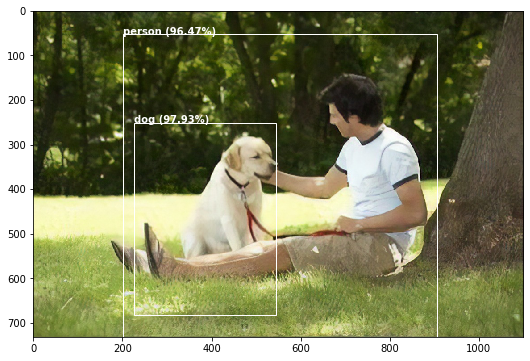

In [46]:
#draw bounding boxes on the actual image and display labels and class prob
draw_boxes(img, boxes, labels, obj_threshold) 